In [ ]:
pip install opencv-python-headless


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imgaug


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 948 kB 26.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 111.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


2023-03-31 06:21:47.931757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 06:21:48.022322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 06:21:48.022691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 06:21:48.025061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

258088960/258076736 [==============================] - 27s 0us/step
Epoch 1/100


2023-03-31 06:22:51.237686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-03-31 06:22:55.813049: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


345/345 [==============================] - 416s 1s/step - loss: 0.1125 - angle_output_loss: 0.0397 - speed_output_loss: 0.0727 - angle_output_mae: 0.1433 - speed_output_mae: 0.1807 - val_loss: 0.0386 - val_angle_output_loss: 0.0135 - val_speed_output_loss: 0.0251 - val_angle_output_mae: 0.0866 - val_speed_output_mae: 0.1040 - lr: 0.0010
Epoch 2/100
345/345 [==============================] - 378s 1s/step - loss: 0.0406 - angle_output_loss: 0.0151 - speed_output_loss: 0.0255 - angle_output_mae: 0.0945 - speed_output_mae: 0.1043 - val_loss: 0.0304 - val_angle_output_loss: 0.0105 - val_speed_output_loss: 0.0199 - val_angle_output_mae: 0.0758 - val_speed_output_mae: 0.0506 - lr: 0.0010
Epoch 3/100
345/345 [==============================] - 375s 1s/step - loss: 0.0330 - angle_output_loss: 0.0125 - speed_output_loss: 0.0204 - angle_output_mae: 0.0853 - speed_output_mae: 0.0913 - val_loss: 0.0346 - val_angle_output_loss: 0.0097 - val_speed_output_loss: 0.0249 - val_angle_output_mae: 0.0720 - v

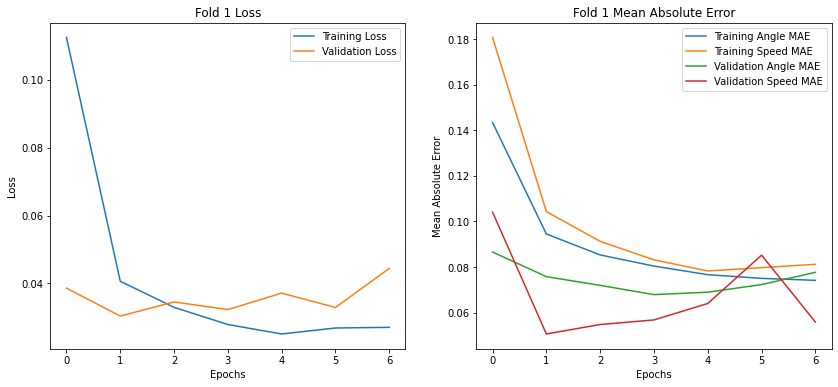

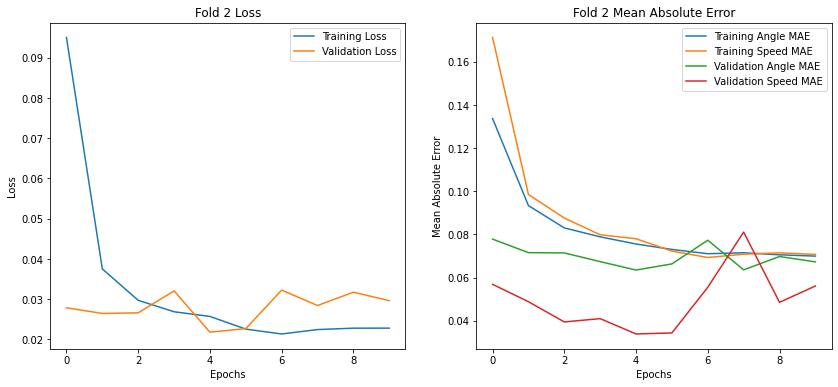

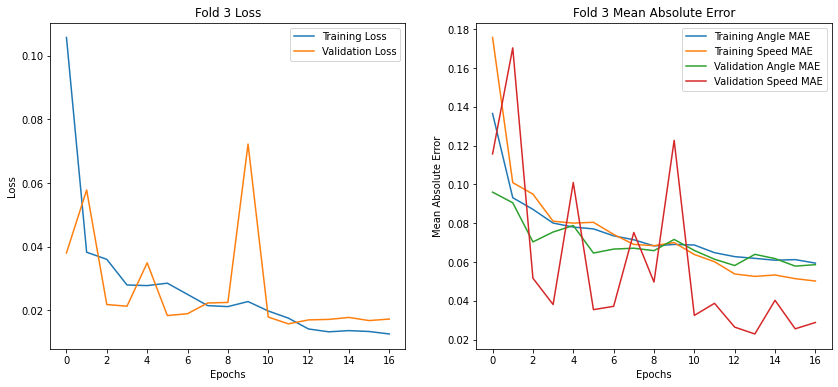

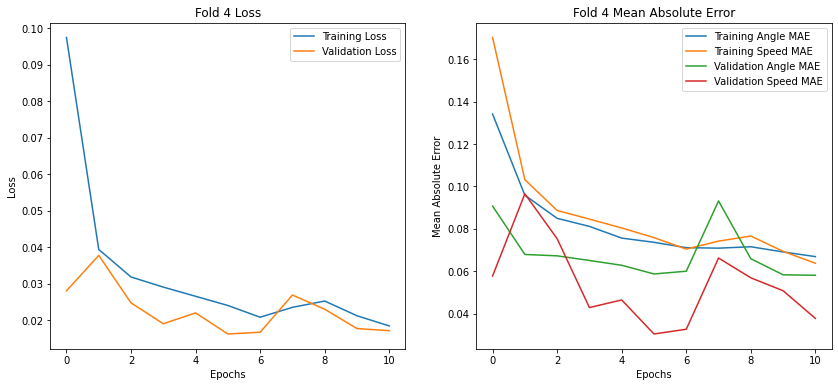

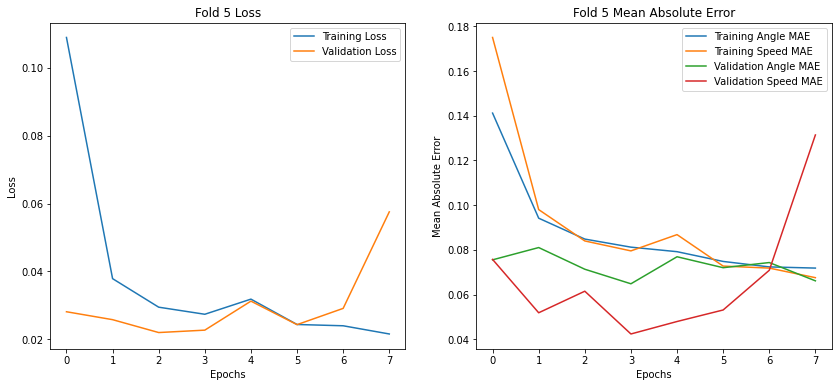

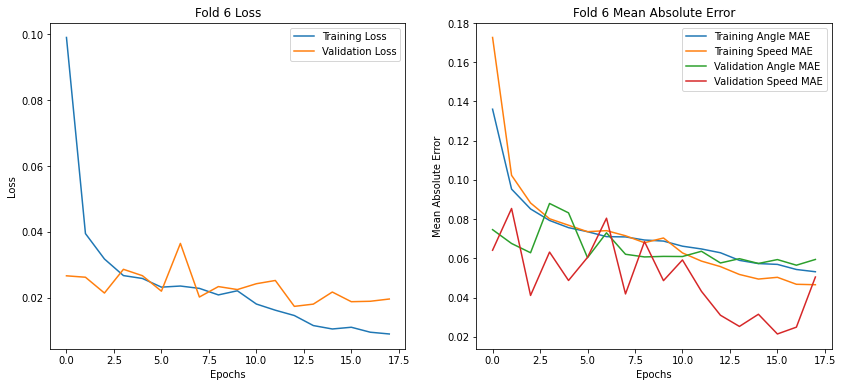

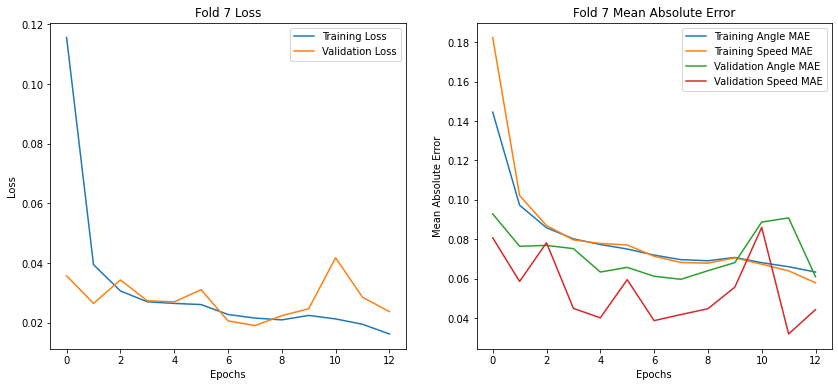

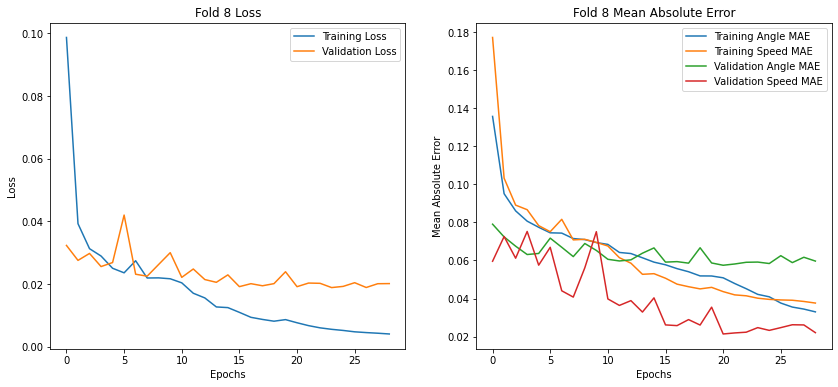

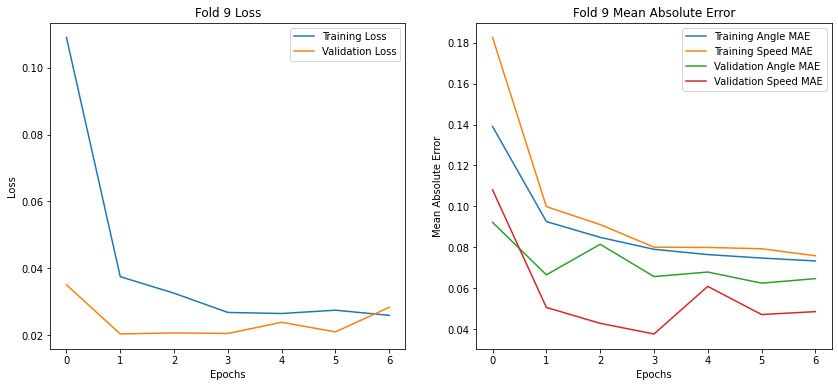

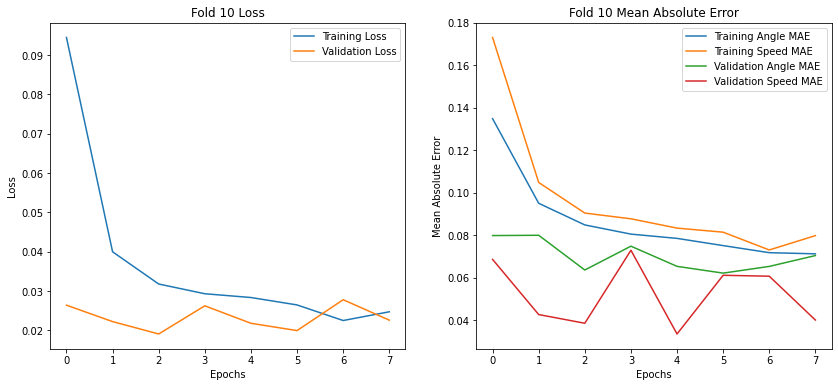

In [ ]:
# ensemble model b5 b7, K-fold, image augmentation
import numpy as np
import pandas as pd
import cv2
import pickle
import imgaug.augmenters as iaa
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB5
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Image augmentation
seq = iaa.Sequential([
    iaa.Multiply((0.8, 1.2)),  # Adjust brightness
    iaa.LinearContrast((0.9, 1.1)),  # Adjust contrast
    iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)),  # Add small amount of noise
    iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},  # Small-scale zoom (±5%)
        rotate=(-3, 3),  # Small rotation (±3°)
        order=[0, 1],  # Nearest neighbour or bilinear interpolation
        mode='reflect'  # Use scikit-image's warping modes
    )
])


# Create models
def create_model(model_name):
    if model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(240, 320, 3))
    elif model_name == 'EfficientNetB5':
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=(240, 320, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    angle_output = Dense(1, name='angle_output')(x)
    speed_output = Dense(1, name='speed_output')(x)
    
    model = Model(inputs=base_model.input, outputs=[angle_output, speed_output])
    
    optimizer = Adam(learning_rate=0.001)
    loss = {'angle_output': 'mean_squared_error', 'speed_output': 'mean_squared_error'}
    metrics = {'angle_output': 'mae', 'speed_output': 'mae'}
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# load train dataset
train_df = pd.read_csv('data/training_norm.csv')
train_images = []
for image_id in train_df['image_id']:
    image = cv2.imread(f'data/training_data/training_data/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_images.append(image)
train_images = np.array(train_images)
train_angles = np.array(train_df['angle'])
train_speeds = np.array(train_df['speed'])

# Apply image augmentation
train_images = seq(images=train_images)

# load test dataset
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'data/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)
test_ids = np.arange(1, 1021)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []
histories = []  # Add this line to create an empty histories list
fold = 1
model_names = ['EfficientNetB7', 'EfficientNetB5']

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_df[['angle', 'speed']].values[train_index], train_df[['angle', 'speed']].values[val_index]
    
    for model_name in model_names:
        model = create_model(model_name)
        model_checkpoint = ModelCheckpoint(f"model_{model_name}_fold_{fold}_best_val_loss.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
        history = model.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=100, batch_size=32, validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), callbacks=[early_stop, lr_scheduler, model_checkpoint])


        models.append(model)
        histories.append(history)  # Add this line to save the history object to the histories list
        print(f"Finished training fold {fold} with model {model_name}")
    
    fold += 1


for i, model in enumerate(models):
    model.save(f"model_{i}.h5")


model_weights = [1 / len(models)] * len(models)
with open("model_weights.pkl", "wb") as f:
    pickle.dump(model_weights, f)


for i, history in enumerate(histories):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Fold {i + 1} Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['angle_output_mae'], label='Training Angle MAE')
    plt.plot(history.history['speed_output_mae'], label='Training Speed MAE')
    plt.plot(history.history['val_angle_output_mae'], label='Validation Angle MAE')
    plt.plot(history.history['val_speed_output_mae'], label='Validation Speed MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title(f'Fold {i + 1} Mean Absolute Error')

    plt.show()


best_model_index = np.argmin([history.history['val_loss'][-1] for history in histories])
best_model = models[best_model_index]
best_model.save("best_model.h5")

# Average the predictions of all models
test_predictions = [model.predict(test_images) for model in models]
test_angle_predictions = np.mean([predictions[0] for predictions in test_predictions], axis=0)
test_speed_predictions = np.mean([predictions[1] for predictions in test_predictions], axis=0)

# speed adjustment
if np.min(test_speed_predictions) < 0:
    test_speed_predictions = test_speed_predictions - np.min(test_speed_predictions)  # if there is a negative num in the spd column
    max_val = np.max(test_speed_predictions)      
    normalized_arr_spd = test_speed_predictions / max_val
    test_speed_predictions = np.where(normalized_arr_spd >= 0.5, 1, 0)
else:
    max_val = np.max(test_speed_predictions)      
    normalized_arr_spd = test_speed_predictions / max_val
    test_speed_predictions = np.where(normalized_arr_spd >= 0.5, 1, 0)

submission_df = pd.DataFrame({
    'image_id': test_ids.flatten(),
    'angle': test_angle_predictions.flatten(),
    'speed': test_speed_predictions.flatten()
})
submission_df.to_csv('submission ensemble.csv', index=False)


In [ ]:
# Calculate the value counts of the 'angle' column and sort them in descending order
angle_value_counts = submission_df['angle'].value_counts().sort_values(ascending=False)

# Print the sorted value counts
print(angle_value_counts)

0.554257    1
0.152015    1
0.717110    1
0.182706    1
0.140189    1
           ..
0.722515    1
0.574204    1
0.540897    1
0.675856    1
0.220762    1
Name: angle, Length: 1020, dtype: int64


In [ ]:
# Load train dataset
train_df = pd.read_csv('data/training_norm.csv')

# Calculate the value counts of the 'angle' column and sort them in descending order
angle_value_counts = train_df['angle'].value_counts().sort_values(ascending=False)

# Print the sorted value counts
print(angle_value_counts)

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64


In [ ]:
unique_angles_train = np.unique(train_df['angle'])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

submission_df['angle'] = submission_df['angle'].apply(lambda x: find_nearest(unique_angles_train, x))

submission_df.to_csv('submission_modified_ensemble.csv', index=False)


In [ ]:
# Calculate the value counts of the 'angle' column and sort them in descending order
angle_value_counts = submission_df['angle'].value_counts().sort_values(ascending=False)

# Print the sorted value counts
print(angle_value_counts)

0.6875    205
0.5000    193
0.7500    154
0.5625    128
0.6250     98
0.4375     59
0.1875     58
0.1250     27
0.2500     24
0.3750     18
0.8125     18
0.3125     14
0.0625     13
0.8750      6
0.9375      2
0.0000      2
1.0000      1
Name: angle, dtype: int64
